In [1]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
from PIL import Image

In [2]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [3]:
label = "all"
folder_path = "/export/home/wuyueting/thyroid_data/BM/8_select5_nodule811_val_test/test/"
model_name = "thyroid_vit_small_5_nodule811"
target_layer="model.blocks[-1].mlp.act"
target_save_name = model_name+target_layer
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def thyroid_main():
    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    # activ.get_same_class_similarity_matrix(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}_similarity.pkl")
    print(f"activs_stats/{target_save_name}/{label}.pkl")
    

    neuron_finding.visualize_all_neuron(model_name,target_layer,image_files,label,\
                                                                                        10,\
                                                                                        f"activs_stats/{target_save_name}",\
                                                                                        f"matching_result/{target_save_name}/{label}/",visualize=True)
    os.makedirs(f"matching_result/{target_save_name}/{label}", exist_ok=True)
    draw_bar_chart(label,f"activs_stats/{target_save_name}/{label}.pkl",save_path=f"matching_result/{target_save_name}/{label}",methods=None)

    
    # device = "cpu"
    if os.path.exists(f'predict_result/{model_name}_predictions.csv'):
        print(f'predict_result/{model_name}_predictions.csv exist!')
    else:
        model,_ = models.load(model_name, device)
        model.eval()

        preprocess =transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.22,), (0.08,))
            ])
        results = []
        for image_path in tqdm(image_files):
            image = Image.open(image_path)
            input_tensor = preprocess(image)
            input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
            output = model(input_tensor)
            BM = image_path.split("/")[-2]
            prediction = output.argmax(dim=1).item()
            # 将结果添加到DataFrame中
            results.append({'Image': image_path, 'BM': BM, 'Prediction': prediction})

        # 使用列表创建DataFrame
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'predict_result/{model_name}_predictions.csv', index=False)

    
    return

# thyroid_main()

In [5]:
def thyroid_sample_explain(i,label,top_number:int=20,importance_matric = "ori_ori",revised=False):

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    # model,_ = models.load(model_name, device)
    # model.eval()

    # preprocess =transforms.Compose([
    #         transforms.Resize((224, 224)),
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.22,), (0.08,))
    #     ])
    

    if isinstance(i,str):
        index = image_files.index(i)
        image_path = i
        i = index
        del index
    else:
        image_path = image_files[i]
    print(image_path)
    
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    
    # 应用BatchNorm
    ori_gradients = data[i, :, 0]
    ori_activations = data[i, :, 2]
    label_dict,neuron_data = get_thyroid_sample_dict("biomedclip",ori_gradients,ori_activations,"TIRADS",top_number=top_number,importance_matric = importance_matric,only_pos=False)
    
    text = summary_sample(label_dict, data ='TIRADS',bar_plot=False)
    
    
    # ##step3:得到分类
    image = Image.open(image_path)
    
    # plt.imshow(image)
    # plt.axis('off')  # 不显示坐标轴
    # # plt.tight_layout()
    # plt.show()
    # 创建图形和子图
    fig_report, ax_report = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 4]})

    # 左边显示图片
    ax_report[0].imshow(image)
    ax_report[0].axis('off')  # 不显示坐标轴

    # 右边显示文本
    text_with_intro = "The feature contribution are:\n" + "\n".join(text)  # 将文本组合成多行字符串
    ax_report[1].text(0.1, 0.5, text_with_intro, fontsize=12, va='center', wrap=True, linespacing=1.5)  # 添加文本
    ax_report[1].axis('off')  # 不显示坐标轴

    # 调整布局
    plt.tight_layout()
    plt.show()

    
    
    if revised:
        description = input("请输入 description: ")
        if description is None:
            return 0
        # 筛选并排序
        filtered_df = neuron_data[neuron_data["description"] == description].sort_values(by="value", ascending=False)
        top_10_df = filtered_df.head(10)

        # 输出结果
        if not top_10_df.empty:
            print("筛选并排序后的前10个结果：")
            print(top_10_df)

            # 打开并显示对应的图片
            # for idx, row in top_10_df.iterrows():
            #     # target_save_name = row["target_save_name"]
            #     neuron_id = row["neuron_id"]
            #     file_path = f"matching_result/{target_save_name}/all/Last_layer_{neuron_id}_neuron.png"

            #     # 检查文件是否存在，然后打开显示
            #     if os.path.exists(file_path):
            #         img = Image.open(file_path)
            #         plt.imshow(img)
            #         plt.axis('off')  # 隐藏坐标轴
            #         # plt.title(f"Neuron ID: {neuron_id}")
            #         plt.show()
            #     else:
            #         print(f"文件未找到：{file_path}")
            

            # 设置子图尺寸和间距
            fig, axes = plt.subplots(len(top_10_df), 2, figsize=(8, len(top_10_df) * 1.2), gridspec_kw={'width_ratios': [1, 3]})
            fig.subplots_adjust(hspace=0, wspace=0)  # 调整子图间距

            # 遍历 DataFrame 的每一行
            for idx, row in enumerate(top_10_df.iterrows()):
                neuron_id = row[1]["neuron_id"]
                file_path = f"matching_result/{target_save_name}/all/Last_layer_{neuron_id}_neuron.png"

                # 左侧显示编号
                axes[idx, 0].text(0.5, 0.5, str(neuron_id), fontsize=12, ha='center', va='center')
                axes[idx, 0].axis('off')  # 去掉坐标轴

                    # 右侧显示图像
                if os.path.exists(file_path):
                    img = Image.open(file_path)
                    axes[idx, 1].imshow(img)
                    axes[idx, 1].axis('off')  # 去掉坐标轴
                else:
                    axes[idx, 1].text(0.5, 0.5, "文件未找到", fontsize=10, ha='center', va='center')
                    axes[idx, 1].axis('off')  # 去掉坐标轴

            # 调整整体布局
            plt.tight_layout()
            plt.show()

            suspicious_neuron = input("请输入被错误激活的neuron的序号（多个用逗号分隔，直接回车表示没有）: ")

            # 处理输入
            if suspicious_neuron.strip():  # 检查是否有输入
                neuron_ids = [int(x.strip()) for x in suspicious_neuron.split(",") if x.strip()]  # 分割并转换为整数
                print("输入的neuron序号为:", neuron_ids)
                return neuron_ids
            else:
                neuron_ids = []  # 如果没有输入则返回空列表
                print("未输入任何neuron序号。")
        else:
            print("未找到匹配的 description")
        
    # input_tensor = preprocess(image)
    # input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
    # output = model(input_tensor)
    # prediction = output.argmax(dim=1).item()
    # if prediction == 0:
    #     print("It's a liang.")
    # elif prediction == 1:
    #     print("It's e.")
    
    return 

In [6]:
abbreviation_dict = {
    "mixed cystic and solid lesion": "MCSL",
    "spongiform lesion": "SPL",
    "circular cyst": "CC",
    "cyst":"CYS",
    "solid lesion": "SOL",
    "anechoic lesion": "AL",
    "isoechoic lesion": "IEL",
    "hypoechoic lesion": "HEL",
    "hyperechoic lesion": "HYPL",
    "oval lesion": "OL",
    "round lesion": "RL",
    "irregular lesion": "IRL",
    "regular lesion": "RGL",
    "lesion with irregular margins": "LIM",
    "lesion with smooth margins": "LSM",
    "lesion with ill-defined margins": "LIDM",
    "lesion with lobulated margins": "LLM",
    "punctate calcified lesion": "PCL",
    "peripheral calcified lesion": "PeCL",
    "massive area calcified lesion": "MACL",
    "homogeneously non-calcified lesion": "HNCL",
    "wider than tall lesion": "WTL",
    "taller than wide lesion": "TWL",
    "vertical oriented lesion": "VOL",
    "horizontal oriented lesion": "HOL",
    "transverse oriented lesion": "TNL",
    "longitudinal oriented lesion": "LNL",
    "wider than tall hypoechoic lesion": "WTHL",
    "taller than wide hypoechoic lesion": "TWHL",
    "low-density lesion": "LDL",
    "equal-density lesion": "EDL",
    "high-density lesion": "HDL",
    "small lesion": "SL",
    "medium lesion": "ML",
    "large lesion": "LL"
}


In [7]:
def summary_sample(label_dict, data ='BIRADS',bar_plot=True):
    
    categories, color_map = get_categories_and_colormap_TIRADS()
    # Assign colors to each row based on its category
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
    df_filtered = pd.DataFrame(list(label_dict.items()), columns=['description', 'values'])
    
    df_filtered['category_color'] = df_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    assert not df_filtered['category_color'].isna().any(), "在'category_color'列中存在NaN值"
    df_filtered = df_filtered[df_filtered['values']>0]
    
    color_order = list(color_map.values())  # 获取颜色的顺序
    color_to_order = {color: i for i, color in enumerate(color_order)}

    # 根据颜色顺序排序 DataFrame
    df_filtered['category_order'] = df_filtered['category_color'].map(color_to_order)

    # 按照颜色顺序和values降序排序
    df_filtered = df_filtered.sort_values(by=['category_order', 'values'], ascending=[True, False])


    # df_filtered = df_filtered.sort_values(by=['category_color', 'values'], ascending=[True, False])
    # bar_width=1
    # positions = range(len(df_filtered['values']))
    # df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    unique_colors = df_filtered['category_color'].unique()
    color_blocks = {color: [] for color in unique_colors}
    last_color = None
    for i, (color, count) in enumerate(zip(df_filtered['category_color'], df_filtered['values'])):
        if color != last_color:
            if last_color is not None:
                color_blocks[last_color][-1].append(i)  # End position of the last block
            color_blocks[color].append([i])  # Start position of the new block
            last_color = color
    color_blocks[last_color][-1].append(i + 1)  # End position of the last block

    
    df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    df_filtered = df_filtered[df_filtered['description']!="Undefined"]
    max_values_by_color = df_filtered.loc[df_filtered.groupby('category_color')['values'].idxmax()]
    max_values_by_color = max_values_by_color.sort_values(by='values', ascending=False)


    # 格式化输出
    formatted_output = max_values_by_color.apply(lambda row: f"{row['description']}({row['values']:.2%})", axis=1).tolist()

    # 打印结果
    # for item in formatted_output:
    #     print(item+",")
    if bar_plot==True:
        # 获取颜色的顺序 (根据 color_map 的顺序)
        # print(df_filtered)
        plt.figure(figsize=(len(df_filtered['values'])//2, 2.5))
        plt.bar(df_filtered['abbreviation'], df_filtered['values'], color=df_filtered['category_color'],width=0.9, align='center')
        
        # plt.bar(df_filtered['description'], df_filtered['values'], color=df_filtered['category_color'],align='edge')

        # Add shaded regions for each color block
        for color, blocks in color_blocks.items():
            for start, end in blocks:
                plt.axvspan(start-0.45, end-0.55 , color=color, alpha=0.4,linewidth=0)
                
        # # 添加图例到图表
        # plt.legend(handles=legend_handles, title="Categories",framealpha=1.0, facecolor='white', loc='right')

        # plt.title('Number of Neuron per Description')
        plt.xticks(rotation=60, ha='right')
        # plt.subplots_adjust(left=-0.05)
        plt.tick_params(axis='y', which='both', pad=2)
        plt.tick_params(axis='x', which='both', length=0)  # 隐藏x轴的刻度线但保留标签
        plt.tick_params(axis='y', which='both', length=0)  # 隐藏y轴的刻度线    
        plt.xlim(-0.5, len(df_filtered['abbreviation']) - 0.5)
        # 去掉边框
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        plt.tight_layout()
        # 显示图表
        # plt.savefig(f'layer{number}.pdf', format='pdf', transparent=True)
        plt.show()
    return formatted_output

In [8]:
def get_categories_and_colormap_TIRADS():
    categories = {
        'Calcification': [
            "punctate calcified lesion", 
            "peripheral calcified lesion",  
            "massive area calcified lesion", 
            "homogeneously non-calcified lesion"
        ],
        'Margin': [
            "lesion with irregular margins", 
            "lesion with smooth margins", 
            "lesion with ill-defined margins", 
            "lesion with lobulated margins" 
        ],
        'Ratio': [
            "wider than tall lesion",  # Original: "wider-than-tall lesion"
            "taller than wide lesion",  # Original: "taller-than-wide lesion"
            "vertical oriented lesion",  # Original: "vertically elongated lesion"
            "horizontal oriented lesion",  # Original: "horizontally elongated lesion"
            "transverse oriented lesion",  # Original: "transverse lesion"
            "longitudinal oriented lesion",  # Original: "longitudinal lesion"
            "wider than tall hypoechoic lesion",
            "taller than wide hypoechoic lesion"
            
        ],
        'Shape': [
            "oval lesion",  
            "round lesion", 
            "irregular lesion",
            "regular lesion" 
        ],
        'Echo': [
            "anechoic lesion",  
            "isoechoic lesion",
            "hypoechoic lesion",
            "hyperechoic lesion" 
        ],
        'Composition': [
            "mixed cystic and solid lesion", 
            "spongiform lesion",  
            "circular cyst", 
            "cyst",
            "solid lesion"
        ],
        'Density': [
            "low-density lesion",  # Original: "low-density lesion"
            "equal-density lesion",  # Original: "equal-density lesion"
            "high-density lesion"  # Original: "high-density lesion"
        ],
        'Size': [
            "small lesion",  # Original: "small lesion"
            "medium lesion",  # Original: "medium lesion"
            "large lesion",  # Original: "large lesion"
        ],
    }

    color_map = {
        'Calcification': '#D7B6FC',
        'Margin': '#CACBFC',
        'Ratio':'#B6EEFC',
        'Shape': '#C9EEBC',
        'Echo': '#FBDD89',
        'Composition':  '#FFC681',
        'Density':  '#FEA39E',
        'Size':  '#FCA0E0'   
    }
    return categories, color_map

In [9]:
def get_filename(model_name,clipmodel_name):
    if clipmodel_name == "biomedclip":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_10_09_10_28/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_10_09_12_31/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_10_09_12_34/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_10_09_14_54/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_10_09_15_08/descriptions.csv"
        
    return filename

In [10]:
def get_categories_and_colormap():
    categories = {
        
        'TIRADS': [
            "mixed cystic and solid lesion",  # Original: "mixed cystic/solid lesion"
            "spongiform lesion",  # Original: "spongiform lesion"
            "circular cyst",  # Original: "circular cyst"
            "cyst",
            "solid lesion",  # Original: "solid lesion"
            "anechoic lesion",  # Original: "anechoic echo lesion"
            "isoechoic lesion",  # Original: "isoechoic echo lesion"
            "hypoechoic lesion",  # Original: "hypoechoic echo lesion"
            "hyperechoic lesion",  # Original: "hyperechoic echo lesion"
            "lesion with irregular margins",  # Original: "marginal irregular lesion"
            "lesion with smooth margins",  # Original: "marginal smooth lesion"
            "lesion with ill-defined margins",  # Original: "marginal ill-defined lesion"
            "lesion with lobulated margins",  # Original: "marginal lobulated lesion"
            "punctate calcified lesion",  # Original: "punctate calcified lesion"
            "peripheral calcified lesion",  # Original: "peripheral calcified lesion"
            "massive area calcified lesion",  # Original: "massive area calcified lesion"
            "homogeneously non-calcified lesion",
            "longitudinal oriented lesion",
            "transverse oriented lesion",
            "vertical oriented lesion",
            "horizontal oriented lesion",
            "wider than tall lesion",
            "taller than wide lesion",
            "wider than tall hypoechoic lesion",
            "taller than wide hypoechoic lesion",
            
            
        ],
        'Shape': [
            "oval lesion",  # Original: "oval shape lesion"
            "round lesion",  # Original: "round shape lesion"
            "irregular lesion",  # Original: "irregular shape lesion"
            "regular lesion"  # Original: "regular shape lesion"
        ],
        'Size': [
            "small lesion",  # Original: "small lesion"
            "medium lesion",  # Original: "medium lesion"
            "large lesion",  # Original: "large lesion"
        ],
        'Density': [
            "low-density lesion",  # Original: "low-density lesion"
            "equal-density lesion",  # Original: "equal-density lesion"
            "high-density lesion"  # Original: "high-density lesion"
        ]
    }
    #'#FFA07A', '#97C8AF', '#ADD8E6'
    color_map = {
        'Size': '#ADD8E6',
        'TIRADS': '#BEB8DC',
        'Density':'#F2CF7E',
        'Shape':'#F1AD7F'
    }
    return categories, color_map


In [11]:
def get_thyroid_sample_dict(clipmodel_name, ori_gradients, ori_activations,label_data="TIRADS", top_number:int=25,importance_matric = "abs_ori", only_pos=False):
    
    ## Standardization
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
        
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]

    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
    elif gradient_type =="sq":
        gradients = ori_gradients**2
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    elif activation_type == "abs":
        activations = np.abs(ori_activations)
    elif activation_type == "pos":
        min_act = np.min(ori_activations)
        if min_act < 0 :
            activations = ori_activations + np.abs(min_act)
        else:
            activations =  ori_activations
    elif activation_type == "sq":
        activations = ori_activations **2
        
    
    
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number,only_pos=only_pos)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    
    
    filename = get_filename(model_name,clipmodel_name)
    df = pd.read_csv(filename)

    # print(filename)
    # unique_descriptions = set()
    sentence_parts = {}
    neuron_data = []
    
    categories, _ = get_categories_and_colormap_TIRADS()
    for category, tags in categories.items():
        for tag in tags:
            sentence_parts[tag]=0
    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
        neuron_data.append({"neuron_id": id, "description": description, "value": value})
    
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    neuron_df = pd.DataFrame(neuron_data)
    
    del sentence_parts
    
    return result_dict, neuron_df

### prune test

In [12]:
from pruning import evaluate_model
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

def prune_feature_maps(model, layer_name, responsive_indices):
    layers = [eval(layer_name)]
    def hook_fn(module, input, output):
        # Zero out the selected feature maps
        output[:,:, responsive_indices] = 0
        # output[:, responsive_indices, :, :] = 0
        return output
    
    for layer in layers:
        layer.register_forward_hook(hook_fn)


## pruning SOP (for modifying model)

In [13]:
def modified_SOP():
    ## 按照df读取csv文件
    with open(f'predict_result/{model_name}_predictions.csv', 'r') as f:
        predict_result = pd.read_csv(f)
        sample_number = len(predict_result)
        
    predict_wrong_number = 0
    to_be_zero_neuron = set()
    for i in range(sample_number):
        if predict_result['BM'][i] != predict_result['Prediction'][i]:
            predict_wrong_number += 1
            image_name = predict_result['Image'][i].split("/")[-1]
            print(f"sample {image_name} is wrong!")
            neuron_ids = thyroid_sample_explain(i,"all",top_number=600,importance_matric="abs_stn",revised=True)
            print(neuron_ids)
            if neuron_ids is not None:
                to_be_zero_neuron.update(neuron_ids)
        # if predict_wrong_number == 20:
        #     break
            
    to_be_zero_neuron_list = list(to_be_zero_neuron)     
    
        
    # 加载数据
    transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.22, 0.22, 0.22], std=[0.08, 0.08, 0.08])
            ])
    dataset = dataset = datasets.ImageFolder(folder_path, transform=transform)
    test_dataloader = DataLoader(dataset, batch_size=128,num_workers=10, shuffle=False)
        


    model,_ = models.load(model_name, device) 

    original_auc = evaluate_model(model, test_dataloader,device)
    print(f"AUC before modification(auc,acc): {original_auc}")

    prune_feature_maps(model, target_layer, to_be_zero_neuron_list)

    modified_auc = evaluate_model(model, test_dataloader, device)
    print(f"AUC after modification(auc,acc): {modified_auc}")


# modified_SOP()

In [14]:
# ! pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display

# 创建按钮
button = widgets.Button(description="点击我")

# 按钮点击事件处理函数
def on_button_clicked(b):
    print("按钮被点击了！")

# 绑定按钮点击事件
button.on_click(on_button_clicked)

# 显示按钮
display(button)

Button(description='点击我', style=ButtonStyle())

按钮被点击了！


activs_stats/thyroid_vit_small_5_nodule811model.blocks[-1].mlp.act/all.pkl exist!
/export/home/wuyueting/thyroid_data/BM/8_select5_nodule811_val_test/test/1/b15160406145137.jpg


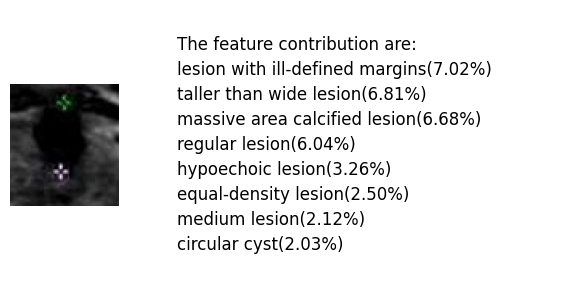

In [15]:
thyroid_sample_explain(700,"all",top_number=600,importance_matric="abs_stn",revised=False)

## BIRADS3

In [16]:
# label_auc(label_data="BIRADS",top_number =600, importance_matric = "abs_stn",clipmodel="biomedclip",batch_norm=False)

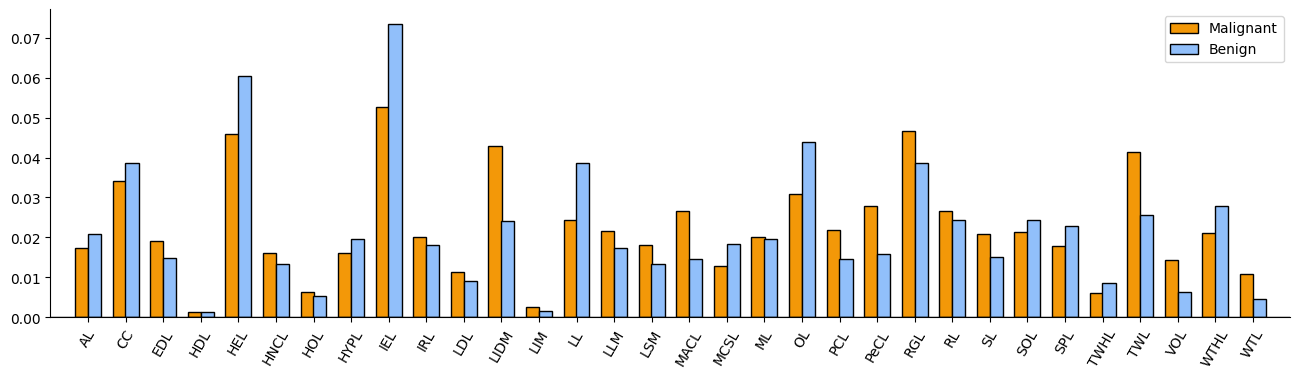

In [17]:
import matplotlib
from matplotlib.ticker import FuncFormatter
def custom_formatter(y, pos):
    if y < 0:
        return f'{-y:.0e}'  # 负值显示为-1
    else:
        return f'{y:.0e}'  # 正值显示为两位小数
def thyroid_global_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)
       
        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = (np.sum(elementwise_product, axis=0)/elementwise_product.shape[0])
        sum_per_neuron/= sum(sum_per_neuron)
        # print(sum(sum_per_neuron))
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    df_clip_filtered = df_clip[df_clip['similarity'] >1]
    df_clip_filtered =df_clip_filtered[['0','1','description']]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('abbr').sum()
    result['abbr'] = result.index
    # result.set_index('abbr', inplace=True)
    


    index = np.arange(len(result))

    # 设置图形的大小
    fig, ax = plt.subplots(figsize=(16, 4))  # 宽度为10英寸，高度为6英寸
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   
    # 设置条形宽度和偏移量
    bar_width = 0.35  # 条形的宽度
    offset = 0.17     # 每组条形之间的偏移量
    # 绘制 '1' 列的条形图
    # ax.bar(index, np.array(result['1']),label='Malignant', facecolor='#F39808', edgecolor='black') ##F0907E

    # # 绘制 '0' 列的条形图，使用负值使其显示在左侧
    # ax.bar(index, 1*np.array(result['0']), label='Benign', facecolor='#91BFFA', edgecolor='black')
    # ax.axhline(0, color='black', linewidth=1, linestyle='-')
    ax.bar(index - offset, np.array(result['1']), width=bar_width, label='Malignant', facecolor='#F39808', edgecolor='black')

    # 绘制 '0' 列的条形图（良性），正值
    ax.bar(index + offset, np.array(result['0']), width=bar_width, label='Benign', facecolor='#91BFFA', edgecolor='black')

    ax.axhline(0, color='black', linewidth=1, linestyle='-')
    # 设置 x 轴的显示范围
    ax.set_xlim(-1, len(result))

    # 设置 x 轴的刻度标签
    ax.set_xticks(index)
    ax.set_xticklabels(result.index, rotation=60)
    
    # max_val = max(max(result['1']), -min(result['0']))  # 找到最大的绝对值
    # y_ticks = np.linspace(-max_val, max_val, num=10)  # 创建10个刻度
    # ax.set_yticks(y_ticks)

    # # 使用 FuncFormatter 格式化 y 轴标签为科学计数法
    # def sci_format(x, pos):
    #     return f"{abs(x):.1e}"

    # formatter = FuncFormatter(sci_format)
    # ax.yaxis.set_major_formatter(formatter)
    ax.legend()
    fig.patch.set_alpha(0.0)
    # ax.set_facecolor('none')
    # 显示图表
    plt.show()
    fig.savefig('test.png', bbox_inches='tight',transparent = True)
thyroid_global_explain()   

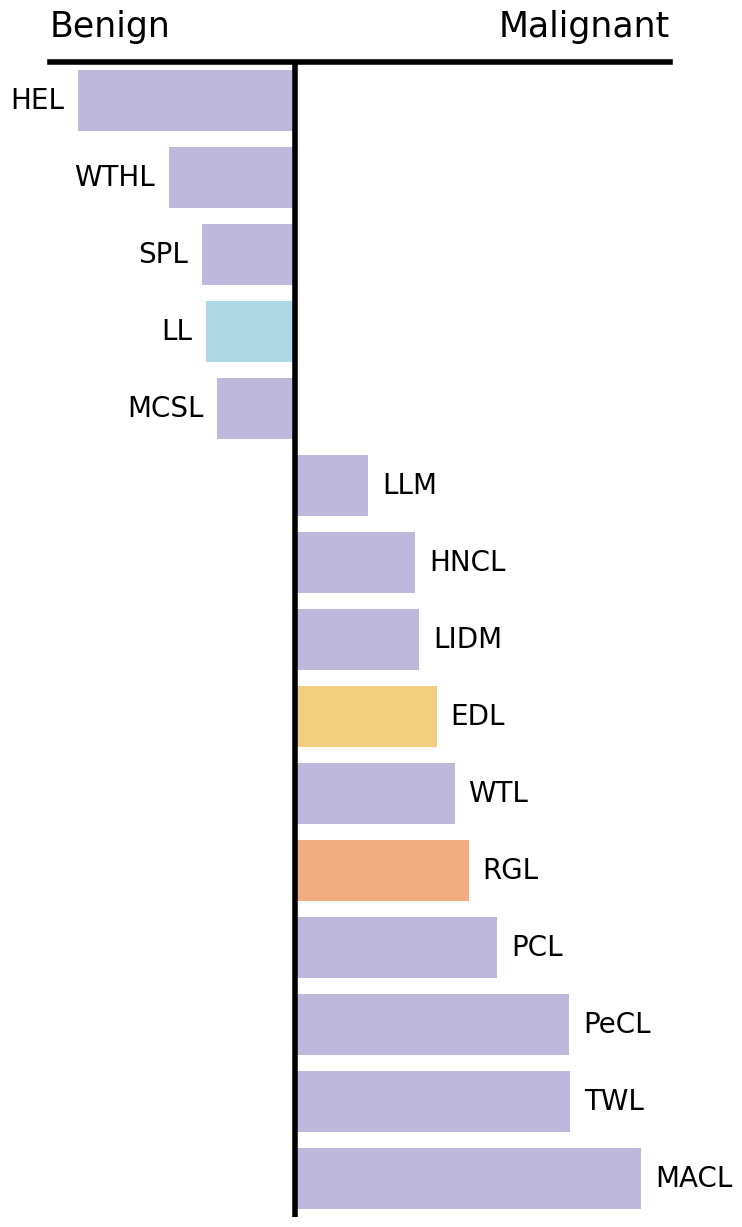

In [18]:
def thyroid_concept_level_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)

        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = np.sum(elementwise_product, axis=0)/elementwise_product.shape[0]
        sum_per_neuron /= sum(sum_per_neuron)
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    # print(df_clip)
    df_clip["expression_difference"] = np.log(np.array(df_clip['1']) / (np.array(df_clip['0'])))
    
    categories,color_map = get_categories_and_colormap()
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
            
    df_clip_filtered = df_clip[df_clip['similarity'] >1]
    # df_clip_filtered['category_color'] = df_clip_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    df_clip_filtered =df_clip_filtered[['0','1','description',"expression_difference"]]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    # df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('description').sum()
    result['description'] = result.index
    result['abbr'] =  result['description'].map(abbreviation_dict)
    result = result.sort_values(by='expression_difference', ascending=False)
    result['category_color'] = result['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    # result["expression_difference"]= np.log(np.array(result['1']) / (np.array(result['0']) + 1e-20))
    
    result_sorted = result.sort_values(by='expression_difference', ascending=False)

    # 分别筛选出大于0和小于0的前5名
    top_positive = result_sorted[result_sorted['expression_difference'] > 0].head(10)
    top_negative = result_sorted[result_sorted['expression_difference'] < 0].tail(5)

    # 合并这两个 DataFrame
    top_results = pd.concat([top_positive, top_negative])[['0','1','abbr',"expression_difference",'category_color']]
    # print(top_results)
    
    fig, ax = plt.subplots(figsize=(8,len(top_results)))  # 宽度为8英寸，高度为12英寸

    # 设置条形宽度
    bar_width = 0.8

    # 绘制 'expression_difference' 列的条形图
    index = np.arange(len(top_results))
    bars = ax.barh(index, top_results['expression_difference'], height=bar_width, color=top_results['category_color'])
    for bar, val, abbr in zip(bars, top_results['expression_difference'], top_results['abbr']):

            # 在柱形旁边添加缩写
            ax.text(val + 1 if val > 0 else val - 1, bar.get_y() + bar.get_height() / 2, abbr,
                    va='center', ha='left' if val > 0 else 'right', fontsize=20, color='black')

    ax.axvline(0, color='black', linewidth=4, linestyle='-')
    
    # 去掉左右和下方边框
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_linewidth(4)
    # ax.spines['top'].set_visible(False)  # 如果你想去掉顶部边框，可以取消注释
    
    # 将 x 轴的刻度和标签移动到顶部
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    ax.xaxis.set_ticks([])  # 隐藏刻度线
    ax.xaxis.set_tick_params(size=0)  # 隐藏刻度线的长度
    ax.tick_params(axis='x', labelsize=12)  # 设置刻度数字的大小
    
    
    xmin, xmax = ax.get_xlim()

    # 获取 y 轴的最大值并稍微减少以靠近顶部轴线
    y_pos = ax.get_ylim()[1] - 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 减少一点高度，贴近 ax.spines['top']

    # 在 x 轴左边写 'benign'
    ax.text(xmin, y_pos+0.2, 'Benign', 
            horizontalalignment='left', 
            verticalalignment='top',  # 使用 'top' 让文本顶部贴近 y_pos
            fontsize=25)

    # 在 x 轴右边写 'malignant'
    ax.text(xmax, y_pos + 0.2, 'Malignant', 
            horizontalalignment='right', 
            verticalalignment='top',  # 使用 'top' 让文本顶部贴近 y_pos
            fontsize=25)


    ax.set_yticks([])  # 去掉 y 轴的刻度
    ax.set_yticklabels([])  # 去掉 y 轴的刻度标签
    
    y_num=np.arange(len(top_results))
    ax.set_ylim(0, 30) 
    ax.set_ylim(min(y_num)-0.5,max(y_num)+0.5)

    # ax.set_title('Expression Difference (Malignant vs. Benign)', fontsize=16)

    plt.show()

    fig.savefig('test_vertical.png',dpi=330, bbox_inches='tight', transparent=True)
thyroid_concept_level_explain()   

In [19]:
import numpy as np
import pandas as pd
import pickle

def thyroid_neuron_level_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl", "rb")
    data = pickle.load(f)  # [IMAGE, NEURON, 3], 3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [], []
    for index, row in prediction_csv.iterrows():
        if row['BM'] == 0 and row['Prediction'] == 0:
            result_0.append(data[index, :, :])
        elif row['BM'] == 1 and row['Prediction'] == 1:
            result_1.append(data[index, :, :])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    # 提取神经元激活值，索引 2 对应 mean_activations
    activations_0 = df_0[:, :, 2]  # [样本数, 神经元数]
    activations_1 = df_1[:, :, 2]  # [样本数, 神经元数]

    # 计算每个神经元在两类中的平均激活值
    mean_activation_0 = activations_0.mean(axis=0)  # [神经元数]
    mean_activation_1 = activations_1.mean(axis=0)  # [神经元数]

    # 计算类别 1 和类别 0 之间的激活差异
    activation_diff = mean_activation_1 - mean_activation_0

    # 找到激活差异最大的前十名神经元
    top_indices = np.argsort(np.abs(activation_diff))[-10:][::-1]  # 获取前十名索引

    for i, index in enumerate(top_indices):
        print(f"第 {i + 1} 名: 神经元 {index}")
        print(f"该神经元在类别 0 上的平均激活值：{mean_activation_0[index]}")
        print(f"该神经元在类别 1 上的平均激活值：{mean_activation_1[index]}")
        print(f"激活差异（类别 1 - 类别 0）：{activation_diff[index]}")
        print()

# thyroid_neuron_level_explain()
